# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

## 0. Importing libraries

In [49]:
colab = False

if colab:
    !pip install fitter
    !pip install pydot
    !pip install graphviz
    from pathlib import Path
    from google.colab import drive
    drive.mount('/content/drive')

import pandas as pd
import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy import stats

from utils import util

In [50]:
from importlib import reload  
from utils import util
util = reload(util)

In [51]:
# Set random seed for reproducibility

seed = 84 #24 SI, 42 NO, 84 SI
util.fix_random_seed(seed)

## 1. Load and inspect the dataset

### 1.1. Load data

In [58]:
df, df_indexes_test = util.load_data(colab)
print(df.columns)

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


In [53]:
display(df)

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274542,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.918877,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274543,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.950230,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274544,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.602938,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274545,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.877878,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513


In [54]:
# Clean the dataset from the columns that are not useful
to_remove = ['Nome', '99perc', '95perc', '80perc']
df = df.drop(to_remove, axis=1, inplace=False)

# Unique duration values
DURATION = df['duration[h]'].unique()
print('Durations: ', DURATION)

Durations:  [ 1  3  6 12 24]


### 1.2 Geographic plot of locations in northern Italy

In [55]:
# This split is just to make the geographic plot
train_df, val_df, test_df = util.train_val_test_split(df, df_indexes_test)

In [56]:
# Run this cell only once to create the .tif file
'''from osgeo import gdal

# Definire i parametri di georeferenziazione dal file .jpgw
geotransform = [261600.0, 100.0, 0.0, 5296000.0, 0.0, -100.0]

# Aprire il file JPG originale con GDAL
ds = gdal.Open('Italia_tinitaly.jpg', gdal.GA_ReadOnly)

# Creare un driver TIFF per il salvataggio del file
driver = gdal.GetDriverByName('GTiff')

# Creare una copia del file originale, questa volta in formato TIFF
ds_tiff = driver.CreateCopy('Italia_tinitaly.tif', ds, 0)

# Assegnare il sistema di riferimento spaziale e la geotrasformazione al file TIFF
ds_tiff.SetProjection('PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')
ds_tiff.SetGeoTransform(geotransform)

# Salvare e chiudere i dataset
ds_tiff.FlushCache()
ds_tiff = None
ds = None'''


'from osgeo import gdal\n\n# Definire i parametri di georeferenziazione dal file .jpgw\ngeotransform = [261600.0, 100.0, 0.0, 5296000.0, 0.0, -100.0]\n\n# Aprire il file JPG originale con GDAL\nds = gdal.Open(\'Italia_tinitaly.jpg\', gdal.GA_ReadOnly)\n\n# Creare un driver TIFF per il salvataggio del file\ndriver = gdal.GetDriverByName(\'GTiff\')\n\n# Creare una copia del file originale, questa volta in formato TIFF\nds_tiff = driver.CreateCopy(\'Italia_tinitaly.tif\', ds, 0)\n\n# Assegnare il sistema di riferimento spaziale e la geotrasformazione al file TIFF\nds_tiff.SetProjection(\'PROJCS["WGS 84 / UTM zone 32N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORIT

In [57]:
import pandas as pd
from PIL import Image, ImageDraw
from osgeo import gdal

# Carica l'immagine georeferenziata TIFF
image_path = 'img/Italia_tinitaly.tif'
image = Image.open(image_path)

# Calcola le dimensioni dell'immagine
width, height = image.size

# Carica il file TIFF con GDAL per accedere alle informazioni georeferenziate
ds = gdal.Open(image_path)

# Ottieni la geotrasformazione dal dataset
gt = ds.GetGeoTransform()

def world_to_pixel(geo_matrix, x, y):
    """
    Usa la geotrasformazione del dataset per convertire le coordinate geografiche in coordinate pixel
    """
    ulX = geo_matrix[0]
    ulY = geo_matrix[3]
    xDist = geo_matrix[1]
    yDist = geo_matrix[5]
    rtnX = geo_matrix[2]
    rtnY = geo_matrix[4]
    pixel = int((x - ulX) / xDist)
    line = int((ulY - y) / xDist)
    return (pixel, line)

# Crea un oggetto draw per disegnare sull'immagine
draw = ImageDraw.Draw(image)

# Imposta la dimensione del pallino per i punti
point_radius = 20

# Definisci una funzione per disegnare i punti
def draw_points(df, color):
    for index, row in df.iterrows():
        pixel_coords = world_to_pixel(gt, row['X'], row['Y'])
        draw.ellipse(
            (pixel_coords[0] - point_radius, pixel_coords[1] - point_radius, 
             pixel_coords[0] + point_radius, pixel_coords[1] + point_radius),
            fill=color
        )

# Disegna i punti del train set in rosso
draw_points(train_df, 'black')

# Disegna i punti del test set in blu
draw_points(test_df, 'white')

# Salva l'immagine modificata
image.save('img/Italia_tinitaly_with_points.jpg')

# Chiudi l'oggetto dataset di GDAL
ds = None

ModuleNotFoundError: No module named 'osgeo'

### 1.3 Preprocess and split the dataset

In [ ]:
# Standardize the data
df_std = util.standardize(df, 'gumbel')

In [ ]:
# Split the dataset into train, validation and test
train_df_std, val_df_std, test_df_std = util.train_val_test_split(df_std, df_indexes_test)

In [ ]:
# column ID must be integer
train_df_std['ID'] = train_df_std['ID'].astype(int)
val_df_std['ID'] = val_df_std['ID'].astype(int)
test_df_std['ID'] = test_df_std['ID'].astype(int)

# column duration[h] must be integer
train_df_std['duration[h]'] = train_df_std['duration[h]'].astype(int)
val_df_std['duration[h]'] = val_df_std['duration[h]'].astype(int)
test_df_std['duration[h]'] = test_df_std['duration[h]'].astype(int)

/var/folders/73/q15nk7zj12b12wgzsnb2wkwm0000gn/T/ipykernel_10380/1558894576.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_std['ID'] = test_df_std['ID'].astype(int)
/var/folders/73/q15nk7zj12b12wgzsnb2wkwm0000gn/T/ipykernel_10380/1558894576.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_std['duration[h]'] = test_df_std['duration[h]'].astype(int)


In [ ]:
train_df_std.head()

,ID,AMS,mean_IdD,loc,scale,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001,1.221239,28.25,0.890564,0.184415,1,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
1,5001,0.778761,28.25,0.890564,0.184415,1,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
2,5001,1.106796,51.50,0.925308,0.129267,3,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
3,5001,0.893204,51.50,0.925308,0.129267,3,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
4,5001,1.184466,51.50,0.925308,0.129267,3,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952


In [ ]:
train_df_std.describe()

,ID,AMS,mean_IdD,loc,scale,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
count,233218.000000,233218.000000,233218.000000,233218.000000,2.332180e+05,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,...,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000
mean,11047.209328,1.000002,57.047139,0.840403,2.670926e-01,9.196126,0.024646,0.032570,0.042734,0.047496,...,-0.102764,0.028934,-0.070270,-0.067010,0.023610,0.001521,0.037728,0.004899,-0.072880,-0.075678
std,4333.130131,0.375316,31.055424,0.034367,5.204314e-02,8.279490,0.984392,0.986320,0.981766,0.976423,...,0.986101,1.052469,1.018725,1.018695,0.996458,1.002549,0.995037,1.018041,0.989454,1.016837
min,5001.000000,0.008228,5.200000,0.563792,6.394417e-304,1.000000,-1.020500,-1.181048,-1.331852,-1.503806,...,-1.470102,-1.519984,-1.779005,-1.935638,-1.583809,-0.479600,-1.528887,-0.637763,-2.037322,-1.886456
25%,8094.000000,0.746683,34.977778,0.820754,2.357013e-01,3.000000,-0.708747,-0.817296,-0.887690,-0.666054,...,-0.984027,-0.582172,-0.864855,-0.799420,-0.757122,-0.452740,-0.764904,-0.515773,-0.969827,-0.868411
50%,12005.000000,0.931282,49.674286,0.841496,2.668687e-01,6.000000,-0.264208,-0.091967,0.073687,0.116867,...,-0.148547,-0.118672,-0.208966,-0.251402,-0.210103,-0.420647,-0.187105,-0.435802,0.079379,-0.371707
75%,16065.000000,1.171771,70.343750,0.862298,2.976202e-01,12.000000,0.480086,0.640557,0.730073,0.713190,...,0.563731,0.423661,0.582830,0.456927,0.596341,-0.225321,0.667556,-0.095920,0.699596,0.724815
max,20034.000000,6.288661,318.742857,1.000000,6.725157e-01,24.000000,5.244876,3.734721,2.928541,3.520526,...,2.408305,5.536860,3.648605,3.272980,4.323812,7.312002,3.537003,6.218626,2.054450,2.471653


### 1.4 Loc and scale inspection

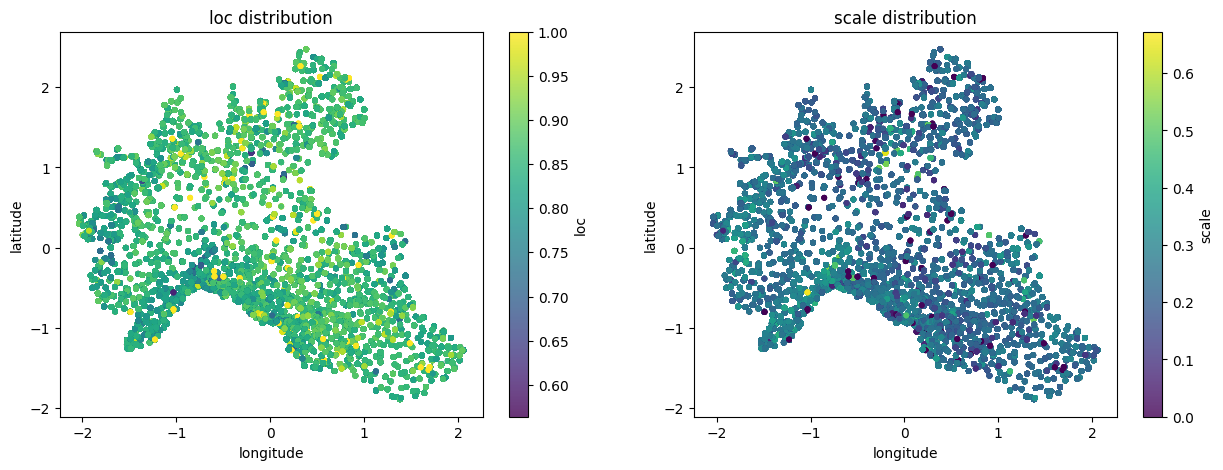

In [ ]:
util.geographic_plot(train_df_std, 'loc', 'scale')

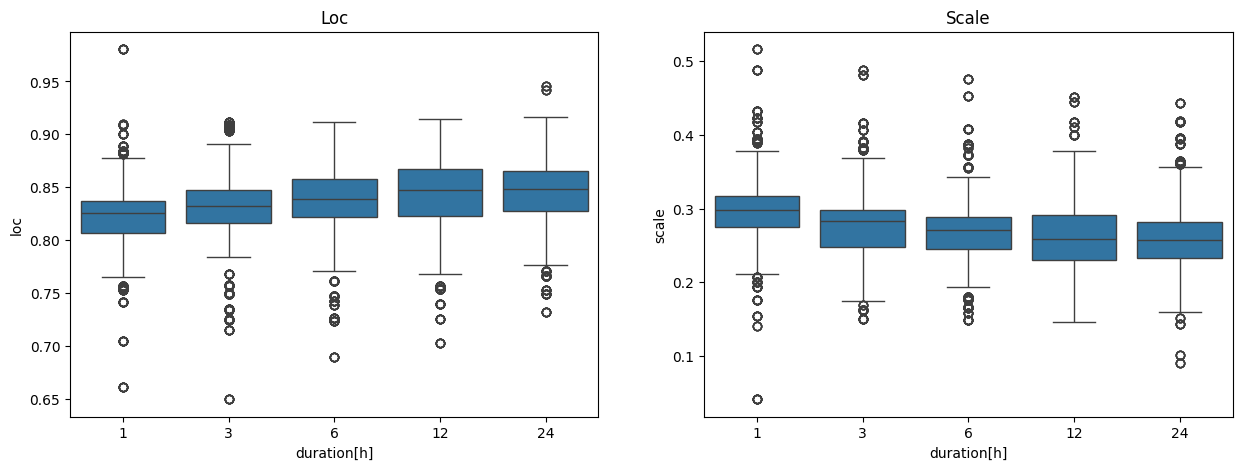

In [ ]:
#boxplot of loc and scale
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x='duration[h]', y='loc', data=test_df_std, ax=ax[0])
ax[0].set_title('Loc')

sns.boxplot(x='duration[h]', y='scale', data=test_df_std, ax=ax[1])
ax[1].set_title('Scale')

plt.show()

In [ ]:
AMS_count = test_df_std.groupby(['ID','duration[h]'])['AMS'].count()
AMS_count = pd.DataFrame(AMS_count)
AMS_count.columns = ['count']
AMS_count['loc'] = test_df_std.groupby(['ID','duration[h]'])['loc'].mean()
AMS_count['scale'] = test_df_std.groupby(['ID','duration[h]'])['scale'].mean()

AMS_count.head(15)

count       loc     scale
ID   duration[h]                           
5005 1               64  0.825731  0.286071
     3               64  0.828158  0.281009
     6               64  0.832412  0.271395
     12              64  0.837870  0.275187
     24              64  0.846214  0.259406
5007 1               20  0.834123  0.286670
     3               20  0.794667  0.330951
     6               20  0.817620  0.306639
     12              20  0.857670  0.262769
     24              20  0.880146  0.225763
5015 1               76  0.858022  0.251708
     3               76  0.879860  0.209240
     6               77  0.880802  0.205946
     12              78  0.877962  0.203477
     24              77  0.868152  0.221819

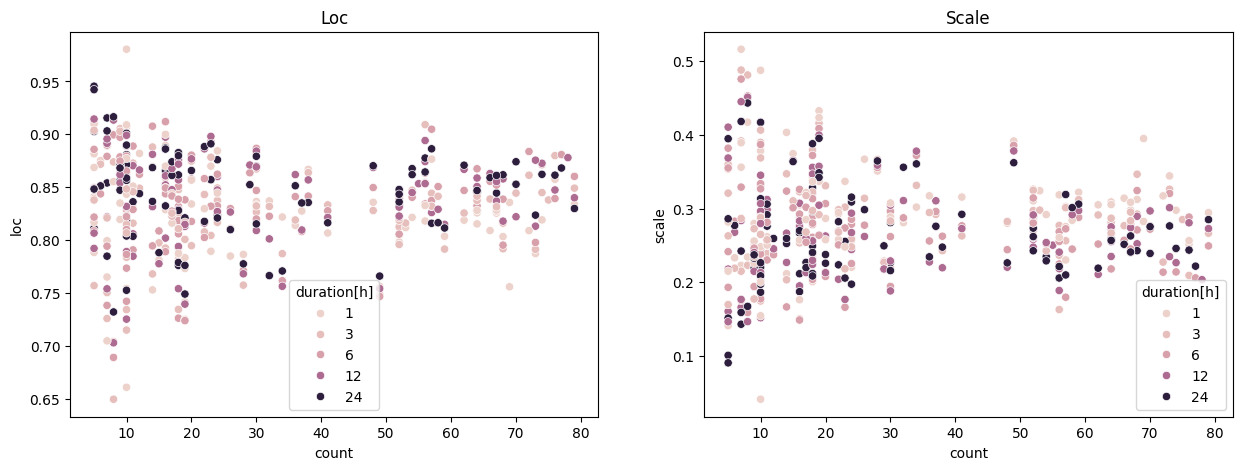

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x='count', y='loc', data=AMS_count, ax=ax[0], hue='duration[h]')
ax[0].set_title('Loc')

sns.scatterplot(x='count', y='scale', data=AMS_count, ax=ax[1], hue='duration[h]')
ax[1].set_title('Scale')

plt.show()

### 1.5 Prepare data for training

In [ ]:
# sort the dataframes by ID and then by duration
train_df_std = train_df_std.sort_values(by=['ID', 'duration[h]'])
val_df_std = val_df_std.sort_values(by=['ID', 'duration[h]'])
test_df_std = test_df_std.sort_values(by=['ID', 'duration[h]'])

# create a dict to store the indexes of same durations
durations_indexes_train = {}
for duration in DURATION:
    durations_indexes_train[duration] = train_df_std[train_df_std['duration[h]'] == duration].index

durations_indexes_val = {}
for duration in DURATION:
    durations_indexes_val[duration] = val_df_std[val_df_std['duration[h]'] == duration].index

durations_indexes_test = {}
for duration in DURATION:
    durations_indexes_test[duration] = test_df_std[test_df_std['duration[h]'] == duration].index

In [ ]:
train_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'loc', 'scale', 'duration[h]',
       'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')

In [ ]:
# take all the columns except 'ID', 'AMS', 'mean_IdD', 'loc', 'scale' as input, and 'AMS' as output
input_columns = train_df_std.columns[5:]  
output_column = 'AMS'
parameters_columns = ['ID', 'duration[h]', 'loc', 'scale']
print('Input columns: ', input_columns)

Input columns:  Index(['duration[h]', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [ ]:
inputs_train = train_df_std[input_columns]
outputs_train = train_df_std[output_column]
#parameters_train = train_df_std[parameters_columns]

inputs_val = val_df_std[input_columns]
outputs_val = val_df_std[output_column]
#parameters_val = val_df_std[parameters_columns]

inputs_test = test_df_std[input_columns]
outputs_test = test_df_std[output_column]
parameters_test = test_df_std[parameters_columns]

In [ ]:
#make ohe for duration

inputs_train = pd.get_dummies(inputs_train, columns=['duration[h]'])
inputs_val = pd.get_dummies(inputs_val, columns=['duration[h]'])
inputs_test = pd.get_dummies(inputs_test, columns=['duration[h]'])

for duration in DURATION:
    inputs_train['duration[h]_'+str(duration)] = inputs_train['duration[h]_'+str(duration)].astype(int)
    inputs_val['duration[h]_'+str(duration)] = inputs_val['duration[h]_'+str(duration)].astype(int)
    inputs_test['duration[h]_'+str(duration)] = inputs_test['duration[h]_'+str(duration)].astype(int)

inputs_train

,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),OrogrAdri_max(m),...,MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,1,0,0,0,0
1,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,1,0,0,0,0
2,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
3,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
4,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233213,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,1,0,0
233214,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,1,0,0
233215,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,1,0,0
233216,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,1,0,0


In [ ]:
# Inputs to train a model with only MAP and duration

inputs_train_map = inputs_train[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_val_map = inputs_val[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_test_map = inputs_test[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]

inputs_train_map

,MAP(mm),duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,2.185839,1,0,0,0,0
1,2.185839,1,0,0,0,0
2,2.185839,0,1,0,0,0
3,2.185839,0,1,0,0,0
4,2.185839,0,1,0,0,0
...,...,...,...,...,...,...
233213,-0.125310,0,0,1,0,0
233214,-0.125310,0,0,1,0,0
233215,-0.125310,0,0,1,0,0
233216,-0.125310,0,0,1,0,0


In [ ]:
# Inputs to train a model after applying PCA

inputs_train_pca = util.make_pca(inputs_train, 5)
inputs_val_pca = util.make_pca(inputs_val, 5)
inputs_test_pca = util.make_pca(inputs_test, 5)

inputs_train_pca

,0,1,2,3,4
0,4.122811,-0.393489,-0.708271,5.286254,0.040014
1,4.122811,-0.393489,-0.708271,5.286254,0.040014
2,4.122848,-0.393510,-0.708254,5.286419,0.040041
3,4.122848,-0.393510,-0.708254,5.286419,0.040041
4,4.122848,-0.393510,-0.708254,5.286419,0.040041
...,...,...,...,...,...
233213,5.980432,1.973444,2.164320,-0.433018,0.024112
233214,5.980432,1.973444,2.164320,-0.433018,0.024112
233215,5.980432,1.973444,2.164320,-0.433018,0.024112
233216,5.980432,1.973444,2.164320,-0.433018,0.024112


## 2. Model definition

In [ ]:
def build_nn_gumbel_model(input_shape, hidden, seed):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    
    for h in hidden:
        x = layers.Dense(h, activation='relu',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    
    mu_logsig = layers.Dense(2, activation='linear',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)

    lf = lambda t: tfp.distributions.Gumbel(loc=t[:, :1], scale=(1e-6)+tf.math.exp(t[:, 1:]))
    model_out = tfp.layers.DistributionLambda(lf)(mu_logsig)
    model = keras.Model(model_in, model_out)
    
    return model

## 3. Training

### 3.1  MAP-model

In [ ]:
y_train  = outputs_train.values
y_val = outputs_val.values
y_test = outputs_test.values

In [ ]:
# Hyperparameters for training
hidden_layers = [256,128]
batch_size = 128
epochs = 90 
lr = 1e-3
patience = 30
loss_prof = lambda y_true, dist: -dist.log_prob(y_true)

Training the model with only MAP descriptor...
Epoch 1/90
1823/1823 [==============================] - 3s 1ms/step - loss: 0.3259 - val_loss: 0.2627
Epoch 2/90
1823/1823 [==============================] - 3s 1ms/step - loss: 0.3139 - val_loss: 0.2701
Epoch 3/90
1823/1823 [==============================] - 3s 2ms/step - loss: 0.3103 - val_loss: 0.2651
Epoch 4/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3097 - val_loss: 0.2581
Epoch 5/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3086 - val_loss: 0.2940
Epoch 6/90
1823/1823 [==============================] - 3s 2ms/step - loss: 0.3109 - val_loss: 0.2589
Epoch 7/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3079 - val_loss: 0.2583
Epoch 8/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3078 - val_loss: 0.2613
Epoch 9/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3072 - val_loss: 0.2599
Epoch 10/90
1823/1823 [============

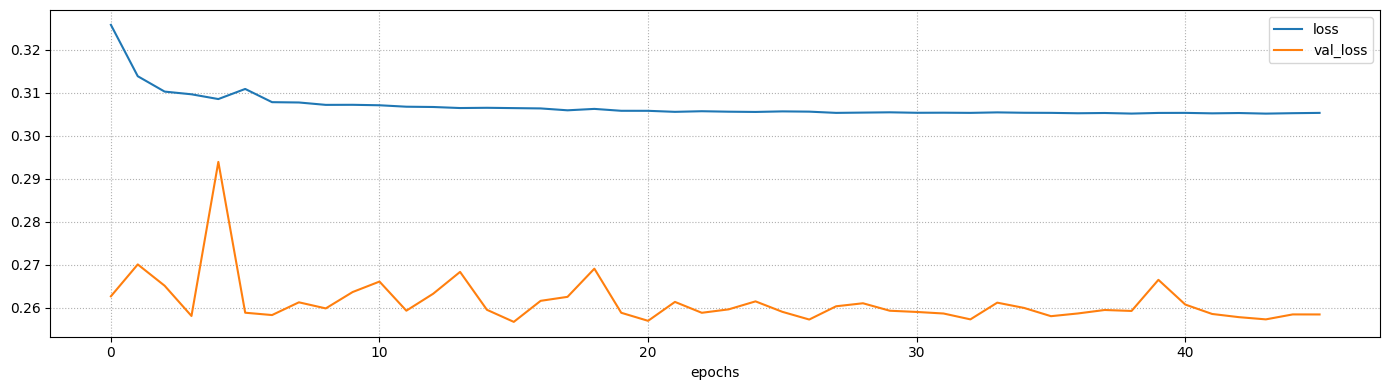

Final loss: 0.3054 (training), 0.2585 (validation)


In [68]:
X_train_map = inputs_train_map.values
X_val_map = inputs_val_map.values
X_test_map = inputs_test_map.values

print('Training the model with only MAP descriptor...')
map_model = build_nn_gumbel_model(input_shape=(X_train_map.shape[1],), hidden=hidden_layers, seed=seed) #[256,128]
history = util.train_nn_model(map_model, X_train_map, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_map, y_val))
util.plot_training_history(history, figsize=(14, 4))

### 3.2 Full-model

Training the model with all morphoclimatic descriptors...
Epoch 1/90
1823/1823 [==============================] - 3s 1ms/step - loss: 0.3428 - val_loss: 0.3140
Epoch 2/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3084 - val_loss: 0.2659
Epoch 3/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3012 - val_loss: 0.2676
Epoch 4/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.2997 - val_loss: 0.2560
Epoch 5/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.2976 - val_loss: 0.3094
Epoch 6/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3010 - val_loss: 0.2641
Epoch 7/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.2952 - val_loss: 0.2672
Epoch 8/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.2943 - val_loss: 0.2586
Epoch 9/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.2930 - val_loss: 0.2571
Epoch 10/90
1823/1823 [=

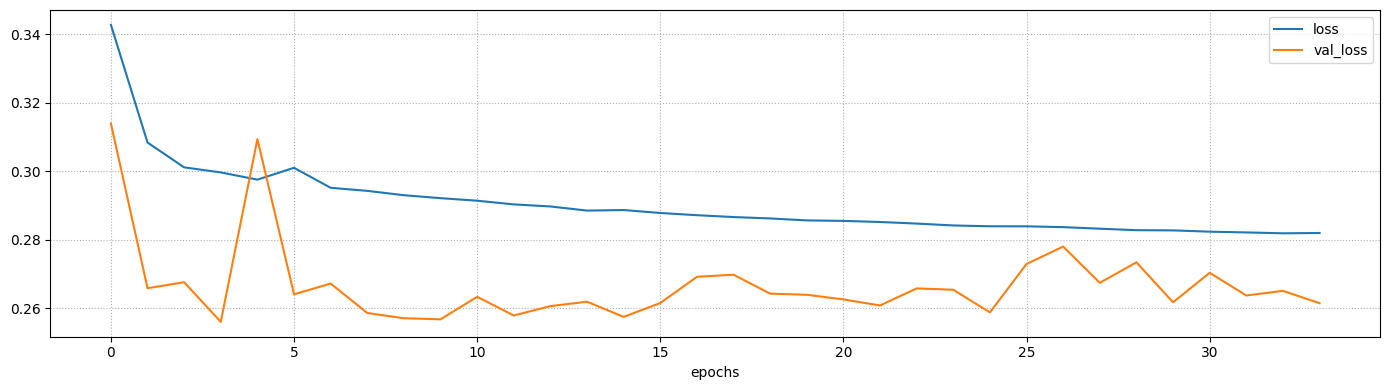

Final loss: 0.2820 (training), 0.2615 (validation)


In [69]:
X_train = inputs_train.values
X_val = inputs_val.values
X_test = inputs_test.values

print('Training the model with all morphoclimatic descriptors...')
full_model = build_nn_gumbel_model(input_shape=(X_train.shape[1],), hidden=hidden_layers,seed=seed) #[256,128]
history = util.train_nn_model(full_model, X_train, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val, y_val))
util.plot_training_history(history, figsize=(14, 4))

### 3.3 PCA-model

Training the model with the PCA of the morphoclimatic descriptors...


Epoch 1/90
1823/1823 [==============================] - 3s 1ms/step - loss: 0.3437 - val_loss: 0.2935
Epoch 2/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3088 - val_loss: 0.2899
Epoch 3/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3042 - val_loss: 0.2703
Epoch 4/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3029 - val_loss: 0.2720
Epoch 5/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3016 - val_loss: 0.2980
Epoch 6/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3059 - val_loss: 0.2787
Epoch 7/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3002 - val_loss: 0.2910
Epoch 8/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3000 - val_loss: 0.2770
Epoch 9/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.2992 - val_loss: 0.2662
Epoch 10/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.298

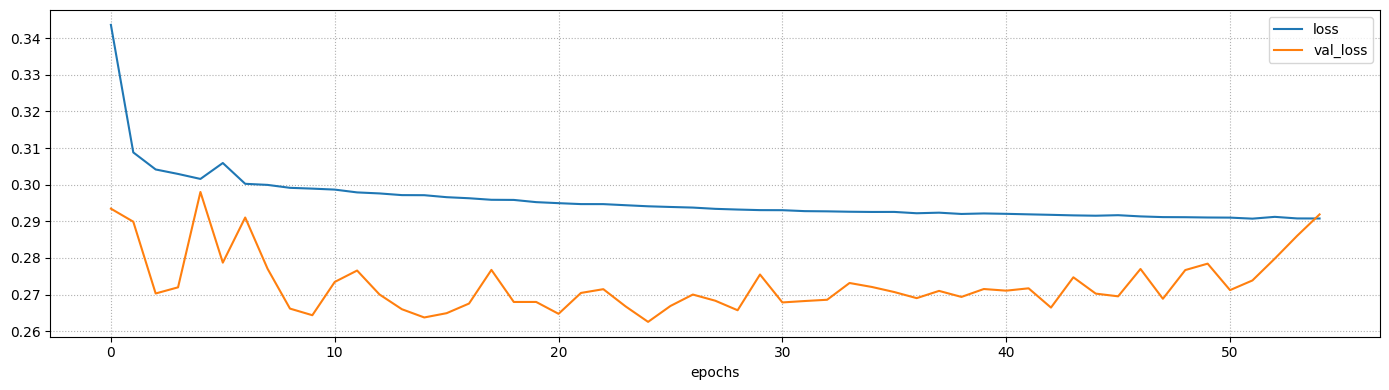

Final loss: 0.2908 (training), 0.2919 (validation)


In [70]:
X_train_pca = inputs_train_pca.values
X_val_pca = inputs_val_pca.values
X_test_pca = inputs_test_pca.values

print('Training the model with the PCA of the morphoclimatic descriptors...')
pca_model = build_nn_gumbel_model(input_shape=(X_train_pca.shape[1],), hidden=hidden_layers,seed=seed) #[256,128]
history = util.train_nn_model(pca_model, X_train_pca, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_pca, y_val))
util.plot_training_history(history, figsize=(14, 4))

## 4. Predictions

In [71]:
dist_train_map = map_model(X_train_map)
dist_val_map = map_model(X_val_map)
dist_test_map = map_model(X_test_map)

dist_train_full = full_model(X_train)
dist_val_full = full_model(X_val)
dist_test_full = full_model(X_test)

dist_train_pca = pca_model(X_train_pca)
dist_val_pca = pca_model(X_val_pca)
dist_test_pca = pca_model(X_test_pca)

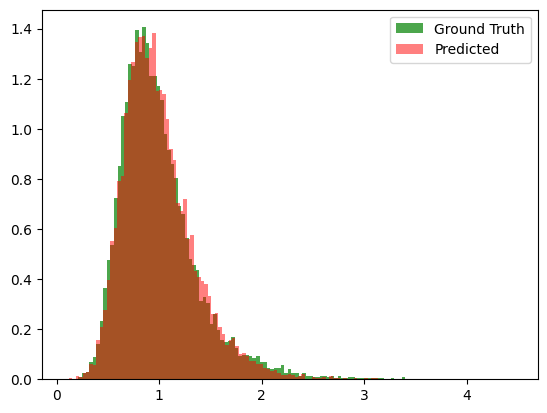

In [72]:
y_pred = dist_test_full.sample(1).numpy().ravel()
#y_pred = dist_train_map.sample(1).numpy().ravel()
#y_pred = dist_test_pca.sample(1).numpy().ravel()

util.plot_hist_samples(y_test, y_pred, 'red')

### 4.1 Confidence interval 

In [73]:
confidence = 0.99

Evaluation of MAP-model based on confidence intervals..


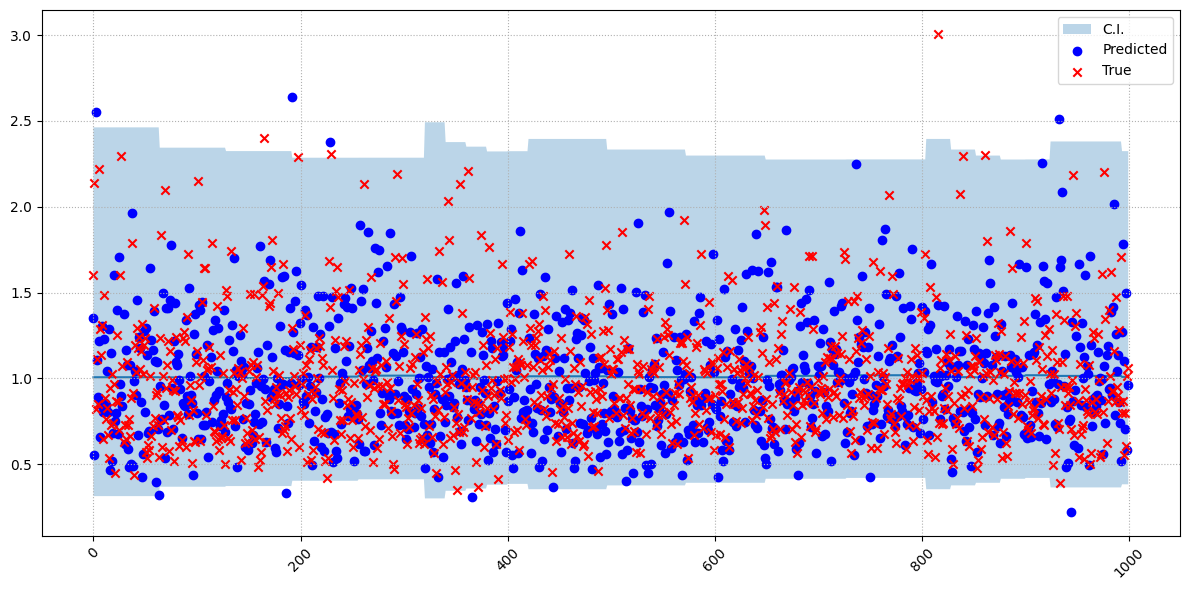

Percentage of values inside the 99% confidence interval: 98.20%


In [74]:
print('Evaluation of MAP-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_map, y_test, dist_test_map, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of Full-model based on confidence intervals..


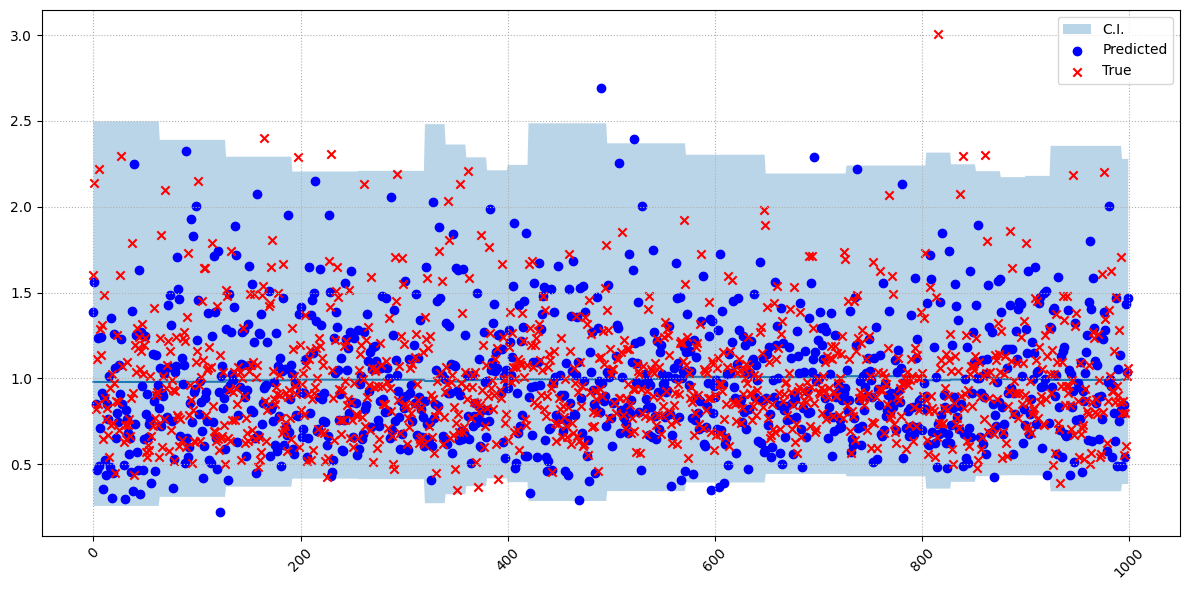

Percentage of values inside the 99% confidence interval: 98.18%


In [75]:
print('Evaluation of Full-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test, y_test, dist_test_full, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of PCA-model based on confidence intervals..


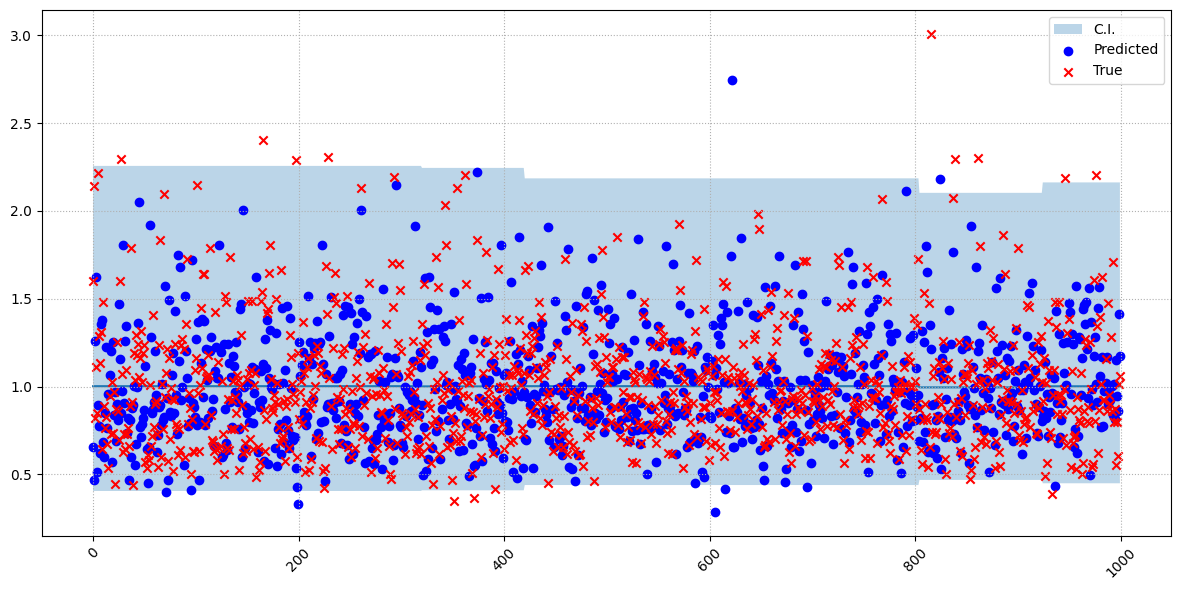

Percentage of values inside the 99% confidence interval: 97.60%


In [76]:
print('Evaluation of PCA-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_pca, y_test, dist_test_pca, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

## 5. Parameters metrics

Metrics on parameters from MAP-model

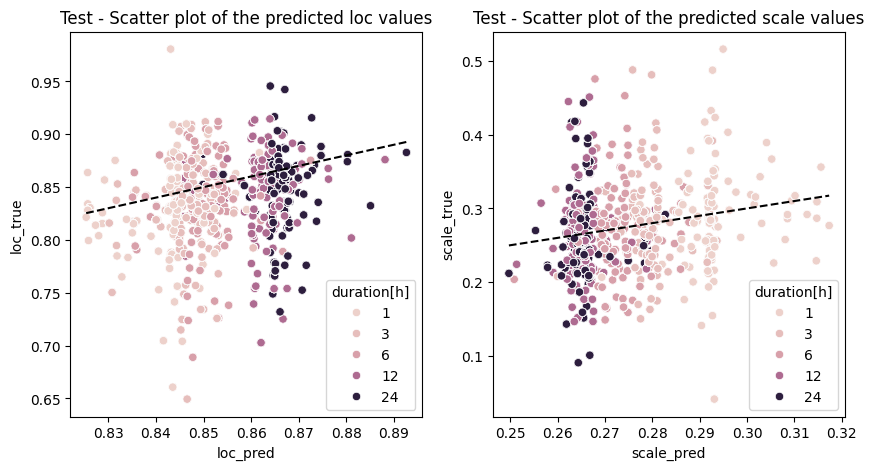

In [77]:
#_ = util.parameters_metrics(dist_train_map, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_map, metrics_scale_map = util.parameters_metrics(dist_test_map, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [78]:
print('===============LOC PARAMETER===============')
display(metrics_loc_map)
print('===============SCALE PARAMETER==============')
metrics_scale_map

===============LOC PARAMETER===============


,global,1,3,6,12,24
biasr,-0.023170,-0.024149,-0.023167,-0.015459,-0.025779,-0.027300
mape,0.034746,0.036734,0.035531,0.032294,0.035243,0.033927
pcc,0.202804,0.098639,0.013503,0.064535,0.033589,0.074316


===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.040091,-0.037629,-0.029688,-0.052596,-0.037435,-0.043109
mape,0.138505,0.137321,0.128291,0.141001,0.145448,0.140465
pcc,0.245395,0.087369,0.002766,0.036735,0.047900,0.019124


Metrics on parameters from Full-model

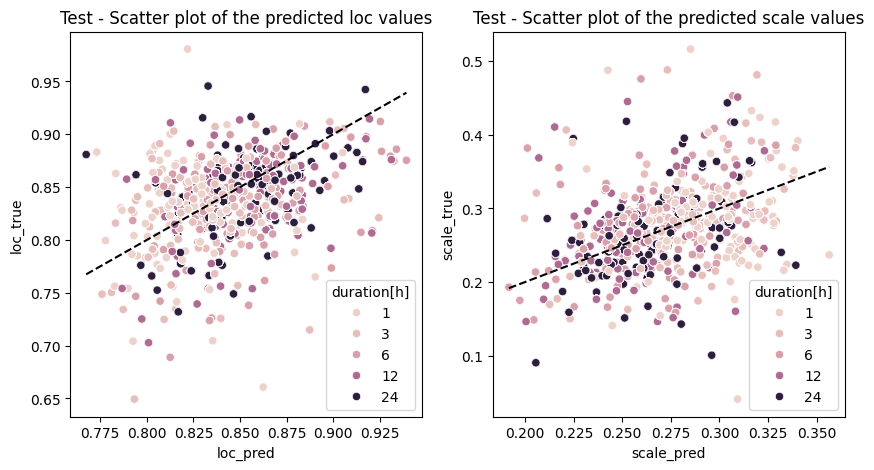

In [79]:
#_ = util.parameters_metrics(dist_train_full, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_full, metrics_scale_full = util.parameters_metrics(dist_test_full, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [80]:
print('===============LOC PARAMETER===============')
display(metrics_loc_full)
print('===============SCALE PARAMETER==============')
metrics_scale_full

===============LOC PARAMETER===============


,global,1,3,6,12,24
biasr,-0.011373,-0.000066,-0.009737,-0.020462,-0.014754,-0.011849
mape,0.033553,0.034105,0.033610,0.035493,0.034370,0.030179
pcc,0.412940,0.138972,0.366585,0.407752,0.428070,0.461563


===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.022241,-0.048032,-0.019039,-0.008687,-0.009342,-0.026102
mape,0.133621,0.147117,0.122851,0.128051,0.138773,0.131304
pcc,0.422158,0.164546,0.386862,0.414352,0.381692,0.416919


Metrics on parameters from PCA-model

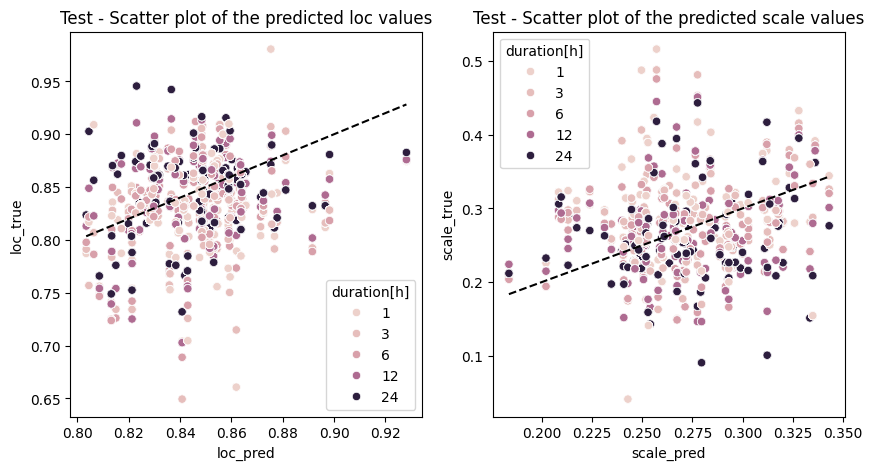

In [81]:
#_ = util.parameters_metrics(dist_train_pca, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_pca, metrics_scale_pca = util.parameters_metrics(dist_test_pca, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [82]:
print('===============LOC PARAMETER===============')
display(metrics_loc_pca)
print('===============SCALE PARAMETER==============')
metrics_scale_full

===============LOC PARAMETER===============


,global,1,3,6,12,24
biasr,-0.015903,-0.030454,-0.022984,-0.012870,-0.008153,-0.005034
mape,0.036867,0.042166,0.038705,0.035182,0.035435,0.032840
pcc,0.183789,0.177823,0.212139,0.216045,0.172195,0.161969


===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.022241,-0.048032,-0.019039,-0.008687,-0.009342,-0.026102
mape,0.133621,0.147117,0.122851,0.128051,0.138773,0.131304
pcc,0.422158,0.164546,0.386862,0.414352,0.381692,0.416919


### 5.1  Comparison between two samples extracted from "true" and predicted distribution of the same place 

True loc: 0.83, Predicted loc: 0.79
True scale: 0.29, Predicted scale: 0.32
KS statistics:  0.0628


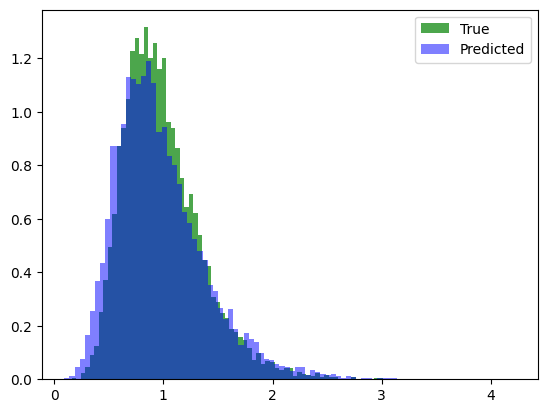

In [83]:
util.compare_samples(dist_test_full, "gumbel", parameters_test, seed = seed, index=1)
#util.compare_samples(dist_test_map, "gumbel", parameters_test, seed = seed, index=1)
#util.compare_samples(dist_test_pca, "gumbel", parameters_test, seed = seed, index=1)

## 6. Save results 


In [84]:
metrics_name = ['biasr', 'mape', 'pcc']
models_name = ['map', 'full', 'pca']
models_metrics = [ metrics_scale_map, metrics_scale_full, metrics_scale_pca]

In [85]:
scale_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
scale_metrics

,biasr_map,biasr_full,biasr_pca,mape_map,mape_full,mape_pca,pcc_map,pcc_full,pcc_pca
global,-0.040091,-0.022241,-0.013428,0.138505,0.133621,0.165969,0.245395,0.422158,0.151728
1,-0.037629,-0.048032,0.056123,0.137321,0.147117,0.169068,0.087369,0.164546,0.133917
3,-0.029688,-0.019039,0.012860,0.128291,0.122851,0.154920,0.002766,0.386862,0.181066
6,-0.052596,-0.008687,-0.033224,0.141001,0.128051,0.165246,0.036735,0.414352,0.204571
12,-0.037435,-0.009342,-0.047633,0.145448,0.138773,0.171550,0.047900,0.381692,0.147583
24,-0.043109,-0.026102,-0.055347,0.140465,0.131304,0.169059,0.019124,0.416919,0.117282


In [86]:
models_metrics = [ metrics_loc_map, metrics_loc_full, metrics_loc_pca]
loc_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
loc_metrics

,biasr_map,biasr_full,biasr_pca,mape_map,mape_full,mape_pca,pcc_map,pcc_full,pcc_pca
global,-0.023170,-0.011373,-0.015903,0.034746,0.033553,0.036867,0.202804,0.412940,0.183789
1,-0.024149,-0.000066,-0.030454,0.036734,0.034105,0.042166,0.098639,0.138972,0.177823
3,-0.023167,-0.009737,-0.022984,0.035531,0.033610,0.038705,0.013503,0.366585,0.212139
6,-0.015459,-0.020462,-0.012870,0.032294,0.035493,0.035182,0.064535,0.407752,0.216045
12,-0.025779,-0.014754,-0.008153,0.035243,0.034370,0.035435,0.033589,0.428070,0.172195
24,-0.027300,-0.011849,-0.005034,0.033927,0.030179,0.032840,0.074316,0.461563,0.161969


In [87]:
#export as pkl file  loc and scale metrics
loc_metrics.to_pickle('results/loc_metrics.pkl')
scale_metrics.to_pickle('results/scale_metrics.pkl')
